In [1]:
import os, sys
sys.path.append('/Users/clancy/repos/approximate_mle/python')
sys.path.append('/Users/clancy/repos/approximate_mle/')
import numpy as np
import pandas as pd
from  loglikelihood import loglikelihood
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.stats
np.seterr(all="ignore");

In [2]:
# total least squares function definition
def TLS(A,b):
    m, n = A.shape
    C = np.hstack((A,b.reshape(m,1)))
    
    # unlike matlab, numpy returns V.T
    _, _, Vt = np.linalg.svd(C)

    # take last row (smallest singular vector)
    v = Vt[-1,:]
    x_tls = -(1/v[-1])*v[:-1]

    return x_tls

In [3]:
df = pd.read_csv('house-prices-advanced-regression-techniques/full.csv')


In [4]:
df = pd.read_csv('house-prices-advanced-regression-techniques/full.csv')
df['totLivArea'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['GrLivArea']

# Focus on residential properties in low density areas and eliminate extreme quantile
myidx = df['MSZoning'] == 'RL'
df = df.loc[myidx,:]
myidx = df.LotArea < df.LotArea.quantile(0.99) 
df = df.loc[myidx,:]
myidx = df.totLivArea < df.totLivArea.quantile(0.99) 
df = df.loc[myidx,:]
myidx = df.SalePrice < df.SalePrice.quantile(0.99)
df = df.loc[myidx,:]



In [5]:
# Focus on the following features that are numeric values
tb = df.loc[:, ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'totLivArea', 'SalePrice']]

# Drop rows that have N/A values
tb.dropna(axis=0,how='any', inplace=True)

# Reset indices so they are more sensible and write as a numpy array
tb.reset_index(inplace=True, drop=True)
TB = np.asarray(tb)
tb

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,totLivArea,SalePrice
0,65.0,8450,7,5,2003,2416.0,208500.0
1,80.0,9600,6,8,1976,2240.0,181500.0
2,68.0,11250,7,5,2001,2272.0,223500.0
3,60.0,9550,7,5,1915,1933.0,140000.0
4,84.0,14260,8,5,2000,2853.0,250000.0
...,...,...,...,...,...,...,...
889,62.0,7917,6,5,1999,1647.0,175000.0
890,85.0,13175,6,6,1978,3026.0,210000.0
891,66.0,9042,7,9,1941,2615.0,266500.0
892,68.0,9717,5,6,1950,2156.0,142125.0


We have selected a subset of data that we want to use to fit a model with. These fields are as follows: LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, GrLivArea, and SalePrice. 

Drawing special attention to quality, condition, and year built, we note that the reported values are necessarily subjective. Why you might ask, this is because we are not given a date which the property was completed. As such, we know that the true data was taken somewhere from January to December of the listed year. Hence, the true year built data should be the listed year plus a number drawn from Uniform(0,1), i.e.,for a year of 2010, the true completion date is year $\in [2010, 2011)$.

For overall quality and condition, this is subjective in nature and there will be some uncertainty. This is the target setup for our method. We don't need to specify true values, we just allow values to be taken over and uncertainty set.

0. LotFrontage: Restrict to tens value (uncertainty is Uniform(-5, 5)) 
1. LotArea: Restrict to hundreds (uncertainty is Uniform(-50, 50)) 
2. OverallQual: No change...our model allows for this uncertainty (uncertainty is Uniform(-0.5, 0.5)) 
3. OverallCond: No change...our model allows for this uncertainty (uncertainty is Uniform(-0.5, 0.5)) 
4. YearBuilt: Add 0.5 to all entries to make it middle of range (uncertainty is Uniform(-0.5, 0.5) not Uniform(0, 1))  
5. GrLivArea: Restrict to hundreds (uncertainty is Uniform(-50, 50)) 
6. SalePrice: Response variable. Determine the variance from the model values and use that for $\sigma^2$


There is no such thing as the true matrix at this point, there is just the observed matrix which we suppose is subject to noise. A few columns are in themselves uncertain, several others are not. 


In [6]:
# Extract features and prices (use centered prices not original ones)
features = TB[:,0:6]
orig_prices = TB[:,-1]
prices = orig_prices - np.mean(orig_prices)

# Shift data so years are centered and can use symmetric uniform noise
A = TB[:,0:6]
A[:,4] = A[:,4] + 0.5

# Center the feature data 
A = A - np.mean(A, axis=0)

# Add column of ones...ways to correct for this, but I don't think any method will work for all instances
A = np.hstack((np.ones((prices.shape[0],1)),A))

dists = ['constant', 'constant', 'constant', 'uniform', 'uniform', 'constant', 'constant', 'normal']
params = [None, None, None, [0.5], [0.5], [0.5], None, [950000000]]


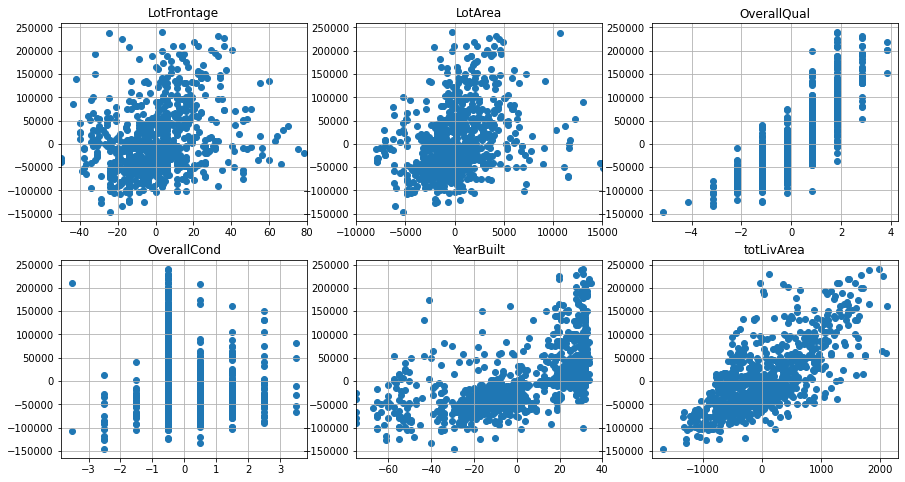

In [7]:
# Plot prices as a function of each variable for simple linear regression (note that these violate
# a number of assumption including homoscedasticity)
plt.figure(figsize=(15,8))
cols = list(tb.columns)
cols.insert(0,'ones')

for i, x in enumerate(A.T):
    if i > 0:
        plt.subplot(2,3,i)
        plt.title(cols[i])
        plt.scatter(x,prices)
        plt.grid()
        if i == 1:
            plt.xlim([-50,80])
        if i == 2:
            plt.xlim([-10000, 15000])
        if i == 5:
            plt.xlim([-75,40])

plt.show()

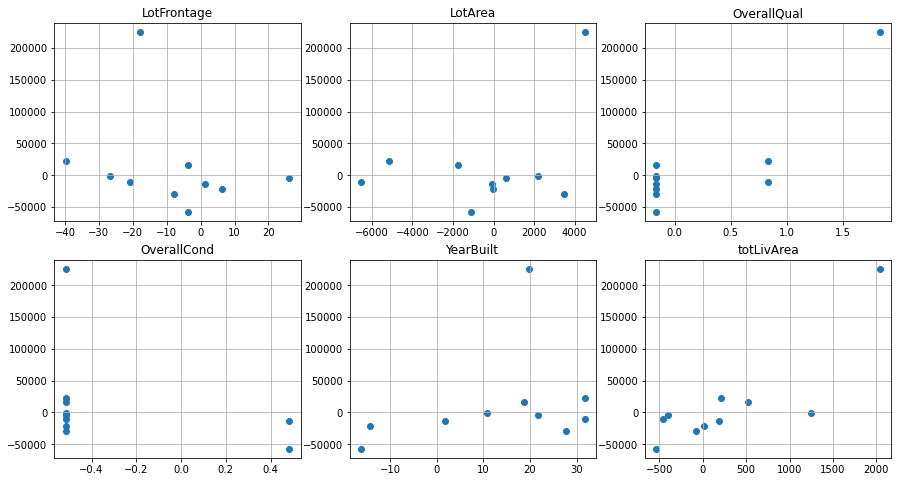

In [8]:
# Select a subset of data to regress on
mSub = 10
idx = np.random.permutation(prices.shape[0])[0:mSub]
Asub = A[idx,:]
pricesSub = prices[idx]
plt.figure(figsize=(15,8))

for i, x in enumerate(A[idx,:].T):
    if i > 0:
        plt.subplot(2,3,i)
        plt.title(cols[i])
        plt.scatter(x, pricesSub)
        plt.grid()
    
plt.show()

In [9]:
np.random.seed(0)

numSims = 500
m = A.shape[0]
ols_err = np.zeros(numSims)
tls_err = np.zeros(numSims)
mle_err = np.zeros(numSims)
ols_err_med = np.zeros(numSims)
tls_err_med = np.zeros(numSims)
mle_err_med = np.zeros(numSims)
ols_err1 = np.zeros(numSims)
tls_err1 = np.zeros(numSims)
mle_err1 = np.zeros(numSims)



m = m - mSub
for i in range(numSims):
    print('Simulation ', i)
    perms = np.random.permutation(prices.shape[0])
    idx = perms[0:mSub]
    nidx = perms[mSub:]
    B = A[idx,:]
    y = prices[idx]
    
    # Solve ols and tls
    xols = np.linalg.lstsq(B,y, rcond=None)[0]
    xtls = TLS(B, y)
    
    # Set initial iterate to zero, initialize MLE, 
    x0 = np.zeros(xols.shape[0])
    lf = loglikelihood(B, y, dists, params)
    neg_ll = lambda z: lf.negative_loglikelihood(z)
    results = optimize.minimize(neg_ll, xols*0.5, method='L-BFGS-B', jac=True)
    xmle = results.x
    
    # Track error metrics 
    # We look at 1 norm error
    C = A[nidx,:]
    z = prices[nidx]
    
    ols_err1[i] = np.linalg.norm(C@xols-z,1)/m
    tls_err1[i] = np.linalg.norm(C@xtls-z,1)/m
    mle_err1[i] = np.linalg.norm(C@xmle-z,1)/m
    
    ols_err[i] = np.linalg.norm(C@xols-z)/np.sqrt(m)
    tls_err[i] = np.linalg.norm(C@xtls-z)/np.sqrt(m)
    mle_err[i] = np.linalg.norm(C@xmle-z)/np.sqrt(m)
    
    ols_err_med[i] = np.median(np.abs(C@xols-z))
    tls_err_med[i] = np.median(np.abs(C@xtls-z))
    mle_err_med[i] = np.median(np.abs(C@xmle-z))
    
    print('Mean OLS1 error', round(ols_err1[i]))
    print('Mean MLE1 error', round(mle_err1[i]))
    print('Median OLS error', round(ols_err_med[i]))
    print('Median MLE error', round(mle_err_med[i]))
    
    

Simulation  0
Mean OLS1 error 39435
Mean MLE1 error 28732
Median OLS error 30783
Median MLE error 23489
Simulation  1
Mean OLS1 error 40131
Mean MLE1 error 35129
Median OLS error 31394
Median MLE error 27008
Simulation  2
Mean OLS1 error 30181
Mean MLE1 error 34956
Median OLS error 23392
Median MLE error 29574
Simulation  3
Mean OLS1 error 27088
Mean MLE1 error 28802
Median OLS error 22279
Median MLE error 23544
Simulation  4
Mean OLS1 error 36461
Mean MLE1 error 35273
Median OLS error 27824
Median MLE error 26143
Simulation  5
Mean OLS1 error 101586
Mean MLE1 error 93763
Median OLS error 72326
Median MLE error 66851
Simulation  6
Mean OLS1 error 44949
Mean MLE1 error 48336
Median OLS error 32800
Median MLE error 33578
Simulation  7
Mean OLS1 error 50385
Mean MLE1 error 34088
Median OLS error 40582
Median MLE error 27898
Simulation  8
Mean OLS1 error 31181
Mean MLE1 error 31397
Median OLS error 20709
Median MLE error 20622
Simulation  9
Mean OLS1 error 34130
Mean MLE1 error 30125
Media

Mean OLS1 error 24573
Mean MLE1 error 26785
Median OLS error 18004
Median MLE error 18716
Simulation  79
Mean OLS1 error 57846
Mean MLE1 error 44084
Median OLS error 47317
Median MLE error 34255
Simulation  80
Mean OLS1 error 26950
Mean MLE1 error 27755
Median OLS error 21692
Median MLE error 21845
Simulation  81
Mean OLS1 error 24785
Mean MLE1 error 24714
Median OLS error 18634
Median MLE error 18469
Simulation  82
Mean OLS1 error 47118
Mean MLE1 error 45533
Median OLS error 44224
Median MLE error 43063
Simulation  83
Mean OLS1 error 42589
Mean MLE1 error 42189
Median OLS error 34545
Median MLE error 34088
Simulation  84
Mean OLS1 error 64678
Mean MLE1 error 32990
Median OLS error 48934
Median MLE error 23435
Simulation  85
Mean OLS1 error 30536
Mean MLE1 error 28333
Median OLS error 23845
Median MLE error 22257
Simulation  86
Mean OLS1 error 52053
Mean MLE1 error 56328
Median OLS error 37691
Median MLE error 40320
Simulation  87
Mean OLS1 error 25767
Mean MLE1 error 24180
Median OLS 

Mean OLS1 error 134905
Mean MLE1 error 36760
Median OLS error 77923
Median MLE error 29144
Simulation  157
Mean OLS1 error 47533
Mean MLE1 error 43027
Median OLS error 35125
Median MLE error 32326
Simulation  158
Mean OLS1 error 54002
Mean MLE1 error 46602
Median OLS error 47645
Median MLE error 39416
Simulation  159
Mean OLS1 error 39002
Mean MLE1 error 36775
Median OLS error 32457
Median MLE error 29333
Simulation  160
Mean OLS1 error 47476
Mean MLE1 error 42546
Median OLS error 36485
Median MLE error 33100
Simulation  161
Mean OLS1 error 24029
Mean MLE1 error 24707
Median OLS error 16747
Median MLE error 17089
Simulation  162
Mean OLS1 error 32779
Mean MLE1 error 34073
Median OLS error 26651
Median MLE error 26267
Simulation  163
Mean OLS1 error 40697
Mean MLE1 error 46234
Median OLS error 31691
Median MLE error 35586
Simulation  164
Mean OLS1 error 36828
Mean MLE1 error 30557
Median OLS error 28927
Median MLE error 24565
Simulation  165
Mean OLS1 error 48640
Mean MLE1 error 47756
M

Mean OLS1 error 45155
Mean MLE1 error 36540
Median OLS error 31343
Median MLE error 26036
Simulation  235
Mean OLS1 error 30149
Mean MLE1 error 28740
Median OLS error 19715
Median MLE error 18700
Simulation  236
Mean OLS1 error 23569
Mean MLE1 error 24595
Median OLS error 18116
Median MLE error 18942
Simulation  237
Mean OLS1 error 28664
Mean MLE1 error 28283
Median OLS error 21247
Median MLE error 20449
Simulation  238
Mean OLS1 error 38245
Mean MLE1 error 41179
Median OLS error 29606
Median MLE error 31953
Simulation  239
Mean OLS1 error 34575
Mean MLE1 error 24894
Median OLS error 26490
Median MLE error 17960
Simulation  240
Mean OLS1 error 33841
Mean MLE1 error 33892
Median OLS error 26566
Median MLE error 26294
Simulation  241
Mean OLS1 error 26176
Mean MLE1 error 28273
Median OLS error 20302
Median MLE error 22285
Simulation  242
Mean OLS1 error 44993
Mean MLE1 error 43578
Median OLS error 31368
Median MLE error 30269
Simulation  243
Mean OLS1 error 26237
Mean MLE1 error 26977
Me

Mean OLS1 error 51402
Mean MLE1 error 50206
Median OLS error 41288
Median MLE error 40183
Simulation  313
Mean OLS1 error 37783
Mean MLE1 error 34923
Median OLS error 29946
Median MLE error 28108
Simulation  314
Mean OLS1 error 31361
Mean MLE1 error 25014
Median OLS error 24285
Median MLE error 19482
Simulation  315
Mean OLS1 error 34086
Mean MLE1 error 34151
Median OLS error 27941
Median MLE error 28153
Simulation  316
Mean OLS1 error 26773
Mean MLE1 error 26944
Median OLS error 19000
Median MLE error 18845
Simulation  317
Mean OLS1 error 86048
Mean MLE1 error 42303
Median OLS error 69032
Median MLE error 34137
Simulation  318
Mean OLS1 error 48900
Mean MLE1 error 37760
Median OLS error 42327
Median MLE error 31691
Simulation  319
Mean OLS1 error 64363
Mean MLE1 error 63002
Median OLS error 44768
Median MLE error 41228
Simulation  320
Mean OLS1 error 33384
Mean MLE1 error 30604
Median OLS error 27621
Median MLE error 24430
Simulation  321
Mean OLS1 error 32032
Mean MLE1 error 29997
Me

Mean OLS1 error 42514
Mean MLE1 error 46182
Median OLS error 34156
Median MLE error 36212
Simulation  391
Mean OLS1 error 32698
Mean MLE1 error 26003
Median OLS error 26010
Median MLE error 19738
Simulation  392
Mean OLS1 error 31772
Mean MLE1 error 31337
Median OLS error 23005
Median MLE error 22718
Simulation  393
Mean OLS1 error 26322
Mean MLE1 error 24141
Median OLS error 18856
Median MLE error 16968
Simulation  394
Mean OLS1 error 27593
Mean MLE1 error 32374
Median OLS error 22464
Median MLE error 25419
Simulation  395
Mean OLS1 error 32552
Mean MLE1 error 32405
Median OLS error 22553
Median MLE error 22511
Simulation  396
Mean OLS1 error 38795
Mean MLE1 error 37606
Median OLS error 27416
Median MLE error 25244
Simulation  397
Mean OLS1 error 55290
Mean MLE1 error 59243
Median OLS error 39422
Median MLE error 39840
Simulation  398
Mean OLS1 error 41074
Mean MLE1 error 31632
Median OLS error 32987
Median MLE error 24153
Simulation  399
Mean OLS1 error 40695
Mean MLE1 error 35104
Me

Mean OLS1 error 35912
Mean MLE1 error 33346
Median OLS error 29621
Median MLE error 27574
Simulation  469
Mean OLS1 error 23918
Mean MLE1 error 23707
Median OLS error 17585
Median MLE error 17664
Simulation  470
Mean OLS1 error 49658
Mean MLE1 error 36872
Median OLS error 38541
Median MLE error 27662
Simulation  471
Mean OLS1 error 47068
Mean MLE1 error 37930
Median OLS error 37670
Median MLE error 28105
Simulation  472
Mean OLS1 error 28265
Mean MLE1 error 29328
Median OLS error 22555
Median MLE error 23694
Simulation  473
Mean OLS1 error 42612
Mean MLE1 error 38750
Median OLS error 33054
Median MLE error 29752
Simulation  474
Mean OLS1 error 24775
Mean MLE1 error 23969
Median OLS error 17563
Median MLE error 17282
Simulation  475
Mean OLS1 error 40258
Mean MLE1 error 34987
Median OLS error 29077
Median MLE error 24319
Simulation  476
Mean OLS1 error 28930
Mean MLE1 error 24758
Median OLS error 21656
Median MLE error 17345
Simulation  477
Mean OLS1 error 39323
Mean MLE1 error 37394
Me

<Figure size 432x288 with 0 Axes>

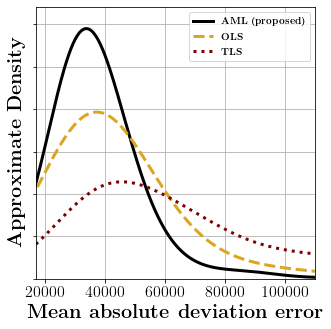

In [33]:


mle_err1temp = mle_err1[mle_err1 < np.quantile(mle_err1, 1)]
ols_err1temp = ols_err1[ols_err1 < np.quantile(ols_err1, 1)]
tls_err1temp = tls_err1[tls_err1 < np.quantile(tls_err1, .9)]



plt.rcParams['text.usetex'] = True
plt.figure()

plt.figure(figsize=(5,5))
bins = np.linspace(15000,110000,1000);
#plt.ylim([0,250])
plt.grid()
ax = plt.gca()
kernel1 = scipy.stats.gaussian_kde(mle_err1temp, bw_method=.8)#'silverman');
kernel2 = scipy.stats.gaussian_kde(ols_err1temp, bw_method=.8)#'silverman');#,ols_err1,tls_err1])
kernel3 = scipy.stats.gaussian_kde(tls_err1temp, bw_method=0.2)#'silverman')#'silverman');#,ols_err1,tls_err1])
plt.plot(bins, kernel1(bins), label=r'\bf{AML (proposed)}', ls='-', color='black', lw=3);
plt.plot(bins, kernel2(bins), label=r'\bf{OLS}',ls='--', color='goldenrod', lw=3);
plt.plot(bins, kernel3(bins), label=r'\bf{TLS}',ls=':', color='maroon', lw=3);
plt.xlabel(r'\bf{Mean absolute deviation error}', fontsize=20)
plt.ylabel(r'\bf{Approximate Density}',fontsize=20)

plt.xlim([17000, 110000])
ax.yaxis.set_ticklabels([])
#plt.legend()


parameters = {'axes.labelsize': 100,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
             'axes.titlesize': 20}
plt.rcParams.update(parameters)
plt.savefig('approx_densities.pdf') 

#plt.title(r'\bf{Mean abs. error by model}')

#plt.xlim([16000, 94000])
plt.ylim([0,3.2e-5])
plt.legend()
plt.savefig('approx_house_densities.pdf')


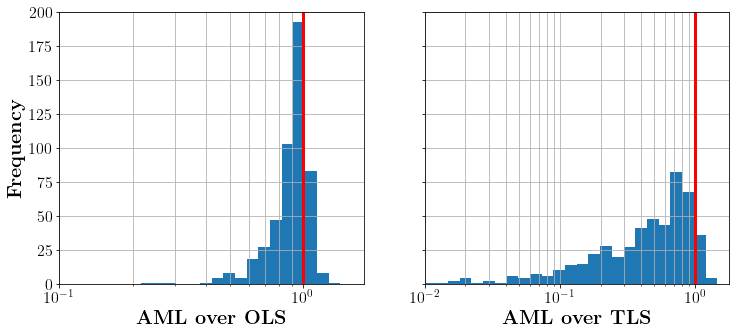

In [34]:
plt.rcParams['text.usetex'] = True

minexp = -1
maxexp = .25
bins = np.logspace(minexp, maxexp,29)
#bins = np.linspace(0.1,1.5,51)
plt.figure(figsize=(12,5))

#print(bins)
plt.subplot(1,2,1)
plt.xscale('log')
bins = np.logspace(-1, maxexp,27)
plt.hist((mle_err1/ols_err1), bins=bins)
plt.grid(which='both')
plt.axvline(x=1, color='red', linewidth=3)
plt.xlim([10**minexp,10**maxexp])
plt.ylim([0,200])
ax = plt.gca()
#ax.yaxis.set_ticklabels([])
plt.xlabel(r"\bf{AML over OLS}", fontsize=20)
plt.ylabel(r'\bf{Frequency}',fontsize=20)
#print(bins)
plt.subplot(1,2,2)
plt.xscale('log')
minexp = -2
maxexp = .25
bins = np.logspace(minexp, maxexp,27)
plt.hist((mle_err1/tls_err1), bins=bins)
plt.grid(which='both')
plt.xlim([10**minexp,10**maxexp])
plt.axvline(x=1, color='red', linewidth=3)
plt.xlabel(r"\bf{AML over TLS}", fontsize=20)
plt.ylim([0,200])
#plt.ylabel(r'\bf{Frequency}',fontsize=20)
ax = plt.gca()
ax.yaxis.set_ticklabels([])


parameters = {'axes.labelsize': 100,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)
#plt.suptitle(r'\bf{Error ratio}', fontsize=24)

plt.savefig('err_ratio.pdf') 

In [28]:

print('\nMedian AMLE 1 norm', np.median(mle_err1))
print('Median OLS 1 norm', np.median(ols_err1))
print('Median TLS 1 norm', np.median(tls_err1))


print('\nMedian AMLE 2 norm', np.median(mle_err))
print('Median OLS 2 norm', np.median(ols_err))
print('Median TLS 2 norm', np.median(tls_err))



print('\nMean AMLE 1 norm', np.mean(mle_err1))
print('Mean OLS 1 norm', np.mean(ols_err1))
#print('Mean TLS 1 norm', np.mean(tls_err1))


print('\nStd in AML 1 norm', np.std(mle_err1))
print('Std in OLS 1 norm', np.std(ols_err1))
#print('Std in TLS 1 norm', np.std(tls_err1))




print('\nMean AMLE 2 norm', np.mean(mle_err))
print('Mean OLS 2 norm', np.mean(ols_err))
#print('Mean TLS 2 norm', np.mean(tls_err))



print('\nStd in MLE 2 norm', np.std(mle_err))
print('Std in OLS 2 norm', np.std(ols_err))
#print('Std in TLS 2 norm', np.std(tls_err))




Median AMLE 1 norm 34567.16035997524
Median OLS 1 norm 38090.2177832895
Median TLS 1 norm 69136.96495354734

Median AMLE 2 norm 46480.42897615199
Median OLS 2 norm 51128.71662821382
Median TLS 2 norm 94809.72892567045

Mean AMLE 1 norm 37602.242733079904
Mean OLS 1 norm 43528.98659435326

Std in AML 1 norm 13385.43886955109
Std in OLS 1 norm 20453.894528854547

Mean AMLE 2 norm 51083.65463017804
Mean OLS 2 norm 58768.18170682661

Std in MLE 2 norm 19110.413321315325
Std in OLS 2 norm 28576.799266358146


In [13]:
m

884